# Proyek Klasifikasi Gambar: Vegetable Dataset
- **Nama:** Ahmad Farhan Juliansyah
- **Email:** ahmadfarhan169@gmail.com
- **ID Dicoding:** farhanjuliansyah

## Import Semua Packages/Library yang Digunakan

In [46]:
!pip install tensorflowjs

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
import random
import seaborn as sns
import tensorflowjs as tfjs
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from PIL import Image
from keras import Sequential, Model
from keras.layers import Input, TFSMLayer

## Data Preparation

### Data Loading

In [2]:
# Upload API kaggle.json ke Colab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farhanjuliansyah","key":"39e1e0b6ed6d389195dfe16111bcfe3b"}'}

In [3]:
# Pindahkan dan Atur Konfigurasi Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download Dataset dari Kaggle
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
 95% 508M/534M [00:01<00:00, 320MB/s]
100% 534M/534M [00:01<00:00, 422MB/s]


In [5]:
# Ekstrak Dataset
!unzip vegetable-image-dataset.zip -d vegetable_dataset

Streaming output truncated to the last 5000 lines.
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: vegetable_dataset/Vegetable Images/train/Radish/0013.jpg  
  inflating: 

In [6]:
# Cek Isi Folder Dataset
base_dir = 'vegetable_dataset'
print(os.listdir(base_dir))

['Vegetable Images']


In [7]:
def cek_resolusi_gambar(folder_dataset):
    total = 0

    # Iterasi tiap kelas (subfolder)
    for kelas in sorted(os.listdir(folder_dataset)):
        path_kelas = os.path.join(folder_dataset, kelas)

        if not os.path.isdir(path_kelas):
            continue  # Lewati jika bukan folder

        jumlah = 0
        ukuran_unik = set()

        # Iterasi tiap gambar dalam kelas
        for file_gambar in os.listdir(path_kelas):
            path_gambar = os.path.join(path_kelas, file_gambar)

            try:
                with Image.open(path_gambar) as img:
                    ukuran_unik.add(img.size)
                    jumlah += 1
            except:
                print(f"Gagal membaca: {path_gambar}")

        print(f"{kelas}: {jumlah}")
        for ukuran in ukuran_unik:
            print(f"- {ukuran}")
        print("---------------")

        total += jumlah

    print(f"\nTotal: {total}")

# Pemanggilan fungsi untuk setiap set
cek_resolusi_gambar('vegetable_dataset/Vegetable Images/train')
cek_resolusi_gambar('vegetable_dataset/Vegetable Images/test')
cek_resolusi_gambar('vegetable_dataset/Vegetable Images/validation')

Bean: 1000
- (224, 224)
---------------
Bitter_Gourd: 1000
- (224, 224)
- (224, 193)
- (224, 205)
- (224, 200)
---------------
Bottle_Gourd: 1000
- (224, 224)
---------------
Brinjal: 1000
- (224, 224)
---------------
Broccoli: 1000
- (224, 224)
---------------
Cabbage: 1000
- (224, 224)
---------------
Capsicum: 1000
- (224, 224)
---------------
Carrot: 1000
- (224, 224)
---------------
Cauliflower: 1000
- (224, 224)
---------------
Cucumber: 1000
- (224, 224)
---------------
Papaya: 1000
- (224, 224)
- (224, 198)
- (224, 210)
- (224, 211)
---------------
Potato: 1000
- (224, 224)
---------------
Pumpkin: 1000
- (224, 224)
---------------
Radish: 1000
- (224, 224)
---------------
Tomato: 1000
- (224, 224)
---------------

Total: 15000
Bean: 200
- (224, 224)
---------------
Bitter_Gourd: 200
- (224, 224)
---------------
Bottle_Gourd: 200
- (224, 224)
---------------
Brinjal: 200
- (224, 224)
---------------
Broccoli: 200
- (224, 224)
---------------
Cabbage: 200
- (224, 224)
----------

### Data Preprocessing

In [8]:
# Direktori asal
base_dir = Path('vegetable_dataset/Vegetable Images')
train_dir = base_dir / 'train'
val_dir = base_dir / 'validation'
test_dir = base_dir / 'test'

# Direktori gabungan
all_data_dir = Path('all_data')
all_data_dir.mkdir(parents=True, exist_ok=True)

# Fungsi alternatif untuk menggabungkan data
def gabungkan_dataset(list_folder_asal, folder_tujuan):
    for folder_asal in list_folder_asal:
        for kelas in os.listdir(folder_asal):
            sumber_kelas = folder_asal / kelas
            tujuan_kelas = folder_tujuan / kelas
            tujuan_kelas.mkdir(parents=True, exist_ok=True)

            for file in os.listdir(sumber_kelas):
                sumber_file = sumber_kelas / file
                tujuan_file = tujuan_kelas / file
                shutil.copy2(sumber_file, tujuan_file)

# Gabungkan semua data ke 'all_data'
gabungkan_dataset([train_dir, val_dir, test_dir], all_data_dir)

print("Semua data berhasil digabung ke folder 'all_data'.")

Semua data berhasil digabung ke folder 'all_data'.


In [9]:
# Menampilkan ringkasan isi dataset gambar
def tampilkan_info_dataset(folder_dataset):
    path_dataset = Path(folder_dataset)
    print(f"Informasi Dataset Vegetable di {path_dataset.name}:\n")

    total = 0
    jumlah_per_label = {}

    for subfolder in sorted(path_dataset.iterdir()):
        if subfolder.is_dir():
            jumlah_gambar = len([file for file in subfolder.iterdir() if file.is_file()])
            jumlah_per_label[subfolder.name] = jumlah_gambar
            total += jumlah_gambar

    print(f"Total Semua Gambar: {total}\n")
    print("Jumlah Gambar Setiap Label:")
    for i, (label, jumlah) in enumerate(jumlah_per_label.items(), start=1):
        print(f"{i}. {label}: {jumlah}")

# Pemanggilan fungsi
tampilkan_info_dataset('all_data')

Informasi Dataset Vegetable di all_data:

Total Semua Gambar: 21000

Jumlah Gambar Setiap Label:
1. Bean: 1400
2. Bitter_Gourd: 1400
3. Bottle_Gourd: 1400
4. Brinjal: 1400
5. Broccoli: 1400
6. Cabbage: 1400
7. Capsicum: 1400
8. Carrot: 1400
9. Cauliflower: 1400
10. Cucumber: 1400
11. Papaya: 1400
12. Potato: 1400
13. Pumpkin: 1400
14. Radish: 1400
15. Tomato: 1400


#### Split Dataset

In [10]:
def split_dataset(source_dir, dest_base_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    random.seed(seed)

    source_path = Path(source_dir)
    dest_train = Path(dest_base_dir) / 'train'
    dest_val = Path(dest_base_dir) / 'val'
    dest_test = Path(dest_base_dir) / 'test'

    for label_dir in sorted(source_path.iterdir()):
        if label_dir.is_dir():
            images = list(label_dir.glob('*'))
            random.shuffle(images)

            total = len(images)
            n_train = int(total * train_ratio)
            n_val = int(total * val_ratio)

            train_images = images[:n_train]
            val_images = images[n_train:n_train + n_val]
            test_images = images[n_train + n_val:]

            for subset, files in zip(
                [dest_train, dest_val, dest_test],
                [train_images, val_images, test_images]
            ):
                label_subset_dir = subset / label_dir.name
                label_subset_dir.mkdir(parents=True, exist_ok=True)

                for file in files:
                    shutil.copy(file, label_subset_dir)

    print("Dataset berhasil di-split ke folder:", dest_base_dir)

# Pemanggilan fungsi
split_dataset('all_data', 'split_data')

Dataset berhasil di-split ke folder: split_data


In [11]:
def tampilkan_ringkasan_split(folder_split):
    folder_split = Path(folder_split)
    subset_names = ['train', 'val', 'test']

    for subset in subset_names:
        subset_path = folder_split / subset
        print(f"\n Subset: {subset.upper()}")
        total = 0
        for i, label_dir in enumerate(sorted(subset_path.iterdir()), start=1):
            if label_dir.is_dir():
                count = len(list(label_dir.glob('*')))
                print(f"{i}. {label_dir.name}: {count}")
                total += count
        print(f"Total gambar di {subset}: {total}")
        print("-" * 30)

# Pemanggilan fungsi
tampilkan_ringkasan_split('split_data')


 Subset: TRAIN
1. Bean: 979
2. Bitter_Gourd: 979
3. Bottle_Gourd: 979
4. Brinjal: 979
5. Broccoli: 979
6. Cabbage: 979
7. Capsicum: 979
8. Carrot: 979
9. Cauliflower: 979
10. Cucumber: 979
11. Papaya: 979
12. Potato: 979
13. Pumpkin: 979
14. Radish: 979
15. Tomato: 979
Total gambar di train: 14685
------------------------------

 Subset: VAL
1. Bean: 210
2. Bitter_Gourd: 210
3. Bottle_Gourd: 210
4. Brinjal: 210
5. Broccoli: 210
6. Cabbage: 210
7. Capsicum: 210
8. Carrot: 210
9. Cauliflower: 210
10. Cucumber: 210
11. Papaya: 210
12. Potato: 210
13. Pumpkin: 210
14. Radish: 210
15. Tomato: 210
Total gambar di val: 3150
------------------------------

 Subset: TEST
1. Bean: 211
2. Bitter_Gourd: 211
3. Bottle_Gourd: 211
4. Brinjal: 211
5. Broccoli: 211
6. Cabbage: 211
7. Capsicum: 211
8. Carrot: 211
9. Cauliflower: 211
10. Cucumber: 211
11. Papaya: 211
12. Potato: 211
13. Pumpkin: 211
14. Radish: 211
15. Tomato: 211
Total gambar di test: 3165
------------------------------


In [12]:
# Direktori dataset
train_dir = 'split_data/train'
val_dir = 'split_data/val'
test_dir = 'split_data/test'

# Konfigurasi augmentasi data untuk training
augmentasi_train = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya normalisasi untuk validasi dan test
augmentasi_val = ImageDataGenerator(rescale=1/255.0)
augmentasi_test = ImageDataGenerator(rescale=1/255.0)

# Membuat generator untuk masing-masing dataset
gen_train = augmentasi_train.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

gen_val = augmentasi_val.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

gen_test = augmentasi_test.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # penting untuk evaluasi/prediksi
)

# Membalik mapping class untuk keperluan interpretasi hasil prediksi
label_index = {v: k for k, v in gen_train.class_indices.items()}
print("Label mapping:", label_index)


Found 14685 images belonging to 15 classes.
Found 3150 images belonging to 15 classes.
Found 3165 images belonging to 15 classes.
Label mapping: {0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


## Modelling

In [13]:
model = Sequential([
    # Layer konvolusi 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer konvolusi 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer konvolusi 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten dan Fully Connected Layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(gen_train.num_classes, activation='softmax')  # output sesuai jumlah kelas
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,830,287 (18.43 MB)

 Trainable params: 4,830,287 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Callback untuk early stopping dan penurunan learning rate
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_accuracy')

In [16]:
# Hitung langkah per epoch
steps_per_epoch = gen_train.samples // gen_train.batch_size
validation_steps = gen_val.samples // gen_val.batch_size

# Melatih model
history = model.fit(
    gen_train,
    epochs=32,
    validation_data=gen_val,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32
229/229 ━━━━━━━━━━━━━━━━━━━━ 786s 3s/step - accuracy: 0.2594 - loss: 2.1950 - val_accuracy: 0.6732 - val_loss: 1.0408 - learning_rate: 0.0010
Epoch 2/32
  1/229 ━━━━━━━━━━━━━━━━━━━━ 9:49 3s/step - accuracy: 0.5938 - loss: 1.3449

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


229/229 ━━━━━━━━━━━━━━━━━━━━ 81s 346ms/step - accuracy: 0.5938 - loss: 1.3449 - val_accuracy: 0.6837 - val_loss: 1.0354 - learning_rate: 0.0010
Epoch 3/32
229/229 ━━━━━━━━━━━━━━━━━━━━ 862s 4s/step - accuracy: 0.5709 - loss: 1.2546 - val_accuracy: 0.7835 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 4/32
229/229 ━━━━━━━━━━━━━━━━━━━━ 81s 343ms/step - accuracy: 0.6250 - loss: 1.0207 - val_accuracy: 0.7822 - val_loss: 0.6973 - learning_rate: 0.0010
Epoch 5/32
229/229 ━━━━━━━━━━━━━━━━━━━━ 862s 4s/step - accuracy: 0.6812 - loss: 0.9507 - val_accuracy: 0.8182 - val_loss: 0.5408 - learning_rate: 0.0010
Epoch 6/32
229/229 ━━━━━━━━━━━━━━━━━━━━ 82s 343ms/step - accuracy: 0.7188 - loss: 0.8244 - val_accuracy: 0.8131 - val_loss: 0.5649 - learning_rate: 0.0010
Epoch 7/32
229/229 ━━━━━━━━━━━━━━━━━━━━ 804s 4s/step - accuracy: 0.7411 - loss: 0.7840 - val_accuracy: 0.8715 - val_loss: 0.4283 - learning_rate: 0.0010
Epoch 8/32
229/229 ━━━━━━━━━━━━━━━━━━━━ 47s 194ms/step - accuracy: 0.7344 - loss: 0.884

## Evaluasi dan Visualisasi

In [18]:
# Evaluasi Model (Data Testing)
test_loss, test_accuracy = model.evaluate(gen_val)
print(f"Akurasi Data Testing: {test_accuracy*100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 853ms/step - accuracy: 0.9464 - loss: 0.1907
Akurasi Data Testing: 95.05%


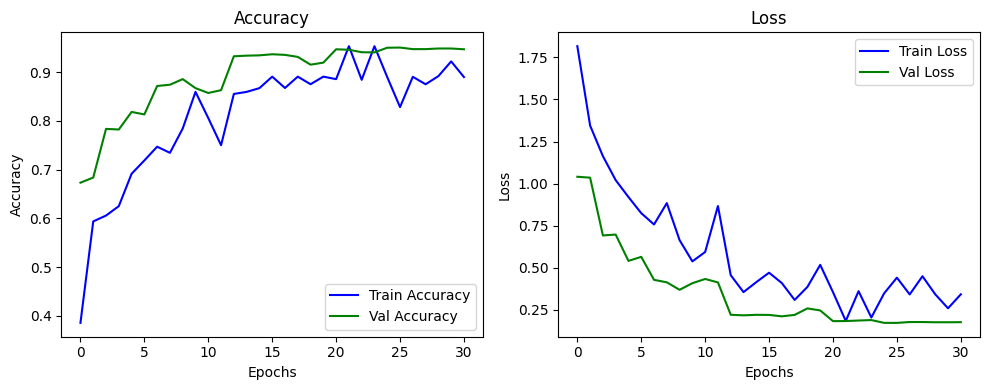

In [23]:
# Membuat canvas plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot akurasi data training dan validasi
axes[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', color='green')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot loss data training dan validasi
axes[1].plot(history.history['loss'], label='Train Loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Val Loss', color='green')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


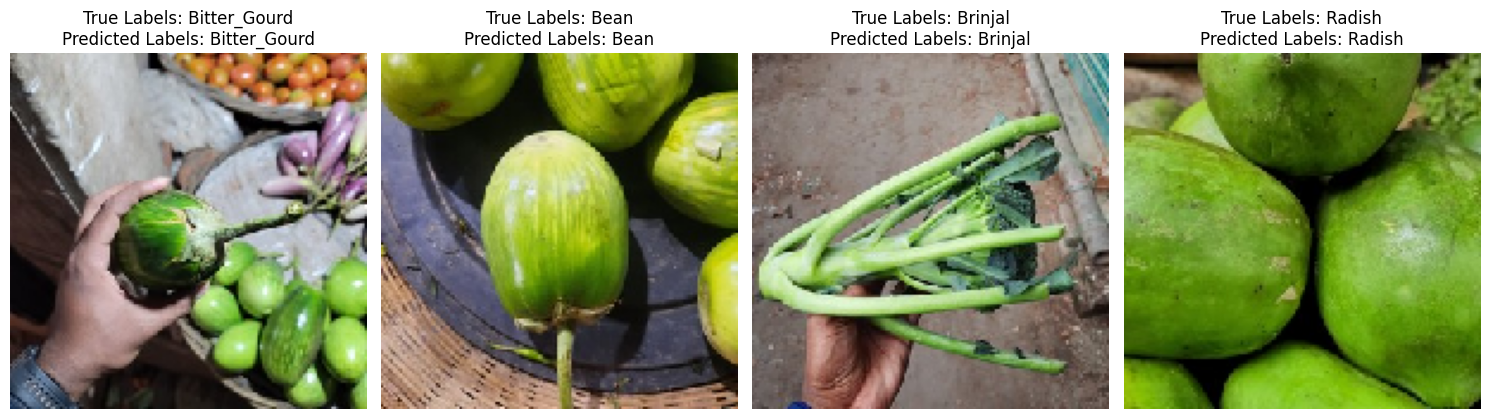

In [40]:
# Fungsi untuk memuat model
def load_model_from_saved():
    return Sequential([
        TFSMLayer("saved_model", call_endpoint="serve")
    ])

# Fungsi untuk memilih batch gambar secara acak
def select_random_images(gen_val, num_images=5):
    for images, labels in gen_val:
        if len(images) < num_images:
            return images, labels, list(range(len(images)))
        else:
            random_indices = random.sample(range(len(images)), num_images)
            return images, labels, random_indices

# Fungsi untuk mendapatkan label asli dan prediksi
def get_labels_and_predictions(model, images, labels, indices, gen_val):
    predictions = []
    true_labels = []

    for idx in indices:
        test_image = images[idx]
        true_label = list(gen_val.class_indices.keys())[np.argmax(labels[idx])]

        # Menambahkan dimensi untuk prediksi batch
        test_image_expanded = np.expand_dims(test_image, axis=0)
        prediction = model.predict(test_image_expanded)
        predicted_class = list(gen_val.class_indices.keys())[np.argmax(prediction[0])]

        true_labels.append(true_label)
        predictions.append(predicted_class)

    return true_labels, predictions

# Fungsi untuk menampilkan gambar secara horizontal
def display_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 5))
    for i in range(min(4, len(images))):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i])
        plt.title(f"True Labels: {true_labels[i]}\nPredicted Labels: {predicted_labels[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Memuat model
model = load_model_from_saved()

# Memilih gambar secara acak dari gen_val
images, labels, random_indices = select_random_images(gen_val)

# Mendapatkan label asli dan prediksi
true_labels, predicted_labels = get_labels_and_predictions(model, images, labels, random_indices, gen_val)

# Menampilkan gambar
display_images(images, true_labels, predicted_labels)

## Konversi Model

In [27]:
# Menyimpan model ke dalam format SavedModel
model.export("saved_model")
print("Model Saved as SavedModel format.")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  135590782769040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590782769808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590782769424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590782772688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590782771920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590782773648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590782773072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590782774032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590782774416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590782775952: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model Saved as Saved

In [76]:
# Mengonversi model yang telah disimpan ke dalam format TensorFlow Lite (.tflite)
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')  # Mengambil model dari SavedModel folder
tflite_model = converter.convert()

# Menyimpan model .tflite ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Menyimpan label dalam format .txt
labels = [
    'Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli',
    'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber',
    'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato'
]

# Menyimpan label ke dalam file .txt
with open('label.txt', 'w') as label_file:
    for label in labels:
        label_file.write(f"{label}\n")

print("Model Converted to TensorFlow Lite format and saved as model.tflite & labels.txt.")

Model Converted to TensorFlow Lite format and saved as model.tflite & labels.txt.


In [56]:
# Menyimpan model dalam format TFJS
!mkdir tfjs_model
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='dense_1/Sigmoid' --saved_model_tags=serve saved_model tfjs_model

print("Model Saved as TFJS format.")

mkdir: cannot create directory ‘tfjs_model’: File exists
2025-05-20 18:19:42.247471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747765182.287277   78997 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747765182.299159   78997 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-20 18:19:47.635419: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1747765187.791914   78997 devices.cc:67] Number of eligible GPUs (c

## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class: [9]


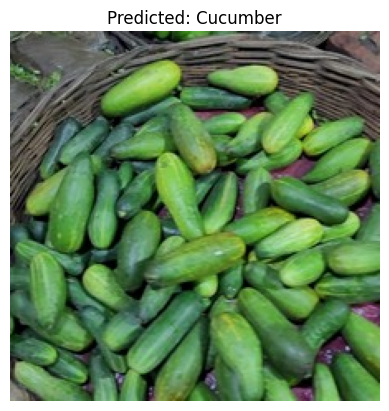

In [74]:
# Fungsi untuk memuat model
def load_model_from_saved():
    # Membuat input tensor dengan ukuran yang sesuai
    input_tensor = Input(shape=(150, 150, 3))

    # Menggunakan TFSMLayer dengan input tensor
    output_tensor = TFSMLayer("saved_model", call_endpoint="serve")(input_tensor)

    # Membuat model Functional
    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Fungsi untuk memproses gambar (resize dan normalisasi)
def preprocess_image(img_path, target_size=(150, 150)):  # Ubah ukuran gambar menjadi 150x150
    img = image.load_img(img_path, target_size=target_size)  # Memuat gambar dengan ukuran target
    img_array = image.img_to_array(img)  # Mengubah gambar menjadi array
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
    img_array /= 255.0  # Menormalisasi gambar (jika model dilatih dengan normalisasi ini)
    return img_array

# Fungsi untuk melakukan prediksi gambar
def predict_image(model, img_path):
    img_array = preprocess_image(img_path)  # Memproses gambar
    prediction = model.predict(img_array)  # Melakukan prediksi dengan model
    predicted_class = np.argmax(prediction, axis=1)  # Mendapatkan kelas yang diprediksi

    return predicted_class

# Fungsi untuk menampilkan gambar dan hasil prediksi
def display_image_with_prediction(img_path, predicted_class, class_names):
    img = image.load_img(img_path)  # Memuat gambar
    plt.imshow(img)  # Menampilkan gambar

    # Debugging untuk melihat apakah prediksi kelas valid
    print("Predicted class:", predicted_class)

    try:
        # Menampilkan kelas prediksi
        plt.title(f"Predicted: {class_names[predicted_class[0]]}")  # Menampilkan kelas prediksi
    except IndexError:
        print(f"Error: predicted_class value {predicted_class[0]} is out of range for class_names.")

    plt.axis('off')
    plt.show()

# Eksekusi langsung

# Memuat model
model = load_model_from_saved()

# Menentukan nama kelas (class_names) sesuai dengan label yang ada
class_names = [
    'Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli',
    'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber',
    'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato'
]

# Lokasi ke gambar yang diprediksi
img_path = 'all_data/Cucumber/0007.jpg'

# Melakukan prediksi pada gambar
predicted_class = predict_image(model, img_path)

# Menampilkan gambar dan prediksi
display_image_with_prediction(img_path, predicted_class, class_names)


In [43]:
# Lokasi Folder & Nama Output .zip
folder_path = 'saved_model'
output_filename = 'saved_model.zip'

# Mengompres folder menjadi file ZIP
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_path)

'/content/saved_model.zip'

In [57]:
# Lokasi Folder & Nama Output .zip
folder_path = 'tfjs_model'
output_filename = 'tfjs_model.zip'

# Mengompres folder menjadi file ZIP
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_path)

'/content/tfjs_model.zip'

In [58]:
# Menyimpan semua dependensi terinstal ke dalam requirements.txt
!pip freeze > requirements.txt